# What Am I Reading?

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score

#### 1. Get Data

The dataset is publicly available and can be downloaded from https://drive.google.com/file/d/1vD4DtyJOIjRzchPtCQu-KPrUjgTiWSmo/view.

In [3]:
def collect_files(file, file_list):
    '''
        Helper function to collect the files from the dataset
    '''
    
    for root, _, files in os.walk(file):
        for file in files:
            file_list.append(os.path.join(root, file))
            
def score_model(model, x_test, y_test):
    '''
        Helper function to score models
    '''
    
    y_pred = model.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=["real", "fake"]).ravel()
    
    print(f"True negatives: {tn} False positives: {fp}\nFalse negatives: {fn} True positives: {tp}\n")
    print(classification_report(y_test, y_pred))

In [4]:
real_arts = []
fake_arts = []

collect_files("NeuralNews/dataset/fake_arts", fake_arts)
collect_files("NeuralNews/dataset/real_arts", real_arts)


# split the data 75:25

real_arts_train, real_arts_test = train_test_split(real_arts,test_size=0.25)
fake_arts_train, fake_arts_test = train_test_split(fake_arts,test_size=0.25)

training_set = real_arts_train + fake_arts_train
training_labels = ['real'] * len(real_arts_train) + ['fake'] * len(fake_arts_train) 

testing_set = real_arts_test + fake_arts_test
testing_labels = ['real'] * len(real_arts_test) + ['fake'] * len(fake_arts_test) 
     

RFC trained on TF-IDF features

In [5]:
# Creating the vectorizer

tfidf_vectorizer = TfidfVectorizer(input='filename', decode_error='ignore')
tfidf_vector = tfidf_vectorizer.fit_transform(training_set)

In [6]:
rfc = RandomForestClassifier(n_estimators=50, max_depth=25)
rfc.fit(tfidf_vector, training_labels)

RandomForestClassifier(max_depth=25, n_estimators=50)

In [7]:
tfidf_test_arts_vector = tfidf_vectorizer.transform(testing_set)

In [8]:
print(f"Evaluating All Articles (RFC):")
score_model(rfc, tfidf_test_arts_vector, testing_labels)

Evaluating All Articles (RFC):
True negatives: 6566 False positives: 1434
False negatives: 1522 True positives: 6478

              precision    recall  f1-score   support

        fake       0.82      0.81      0.81      8000
        real       0.81      0.82      0.82      8000

    accuracy                           0.82     16000
   macro avg       0.82      0.82      0.82     16000
weighted avg       0.82      0.82      0.82     16000



RFC with trigram approach

In [9]:
count_vectorizer = CountVectorizer(input='filename', ngram_range=(3,3) ,decode_error='ignore')
count_vector = count_vectorizer.fit_transform(training_set)

In [10]:
rfc_trigram = RandomForestClassifier(n_estimators=50, max_depth=25)
rfc_trigram.fit(count_vector, training_labels)

RandomForestClassifier(max_depth=25, n_estimators=50)

In [11]:
count_tri_test_arts_vector = count_vectorizer.transform(testing_set)

In [12]:
print(f"Evaluating All Articles (tri-gram approach):")
score_model(rfc_trigram, count_tri_test_arts_vector, testing_labels)

Evaluating All Articles (tri-gram approach):
True negatives: 6462 False positives: 1538
False negatives: 3090 True positives: 4910

              precision    recall  f1-score   support

        fake       0.76      0.61      0.68      8000
        real       0.68      0.81      0.74      8000

    accuracy                           0.71     16000
   macro avg       0.72      0.71      0.71     16000
weighted avg       0.72      0.71      0.71     16000



RFC with 5-gram approach

In [13]:
count_vectorizer = CountVectorizer(input='filename', ngram_range=(5,5) ,decode_error='ignore')
count_vector = count_vectorizer.fit_transform(training_set)

In [14]:
rfc_fivegram = RandomForestClassifier(n_estimators=50, max_depth=25)
rfc_fivegram.fit(count_vector, training_labels)

RandomForestClassifier(max_depth=25, n_estimators=50)

In [15]:
count_five_test_arts_vector = count_vectorizer.transform(testing_set)

In [16]:
print(f"Evaluating All Articles (5-gram approach):")
score_model(rfc_fivegram, count_five_test_arts_vector, testing_labels)

Evaluating All Articles (5-gram approach):
True negatives: 7589 False positives: 411
False negatives: 6206 True positives: 1794

              precision    recall  f1-score   support

        fake       0.81      0.22      0.35      8000
        real       0.55      0.95      0.70      8000

    accuracy                           0.59     16000
   macro avg       0.68      0.59      0.52     16000
weighted avg       0.68      0.59      0.52     16000



Bagging classifier with an RFC as the base estimator

In [17]:
bgc = BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=10, n_jobs=-1)
bgc.fit(tfidf_vector, training_labels)

BaggingClassifier(estimator=RandomForestClassifier(), n_jobs=-1)

In [18]:
print(f"Evaluating All Articles (Bagging Classifier):")
score_model(bgc, tfidf_test_arts_vector, testing_labels)

Evaluating All Articles (Bagging Classifier):
True negatives: 6846 False positives: 1154
False negatives: 1168 True positives: 6832

              precision    recall  f1-score   support

        fake       0.86      0.85      0.85      8000
        real       0.85      0.86      0.86      8000

    accuracy                           0.85     16000
   macro avg       0.85      0.85      0.85     16000
weighted avg       0.85      0.85      0.85     16000



Consolidated metrics of each model

In [19]:
dclf = DummyClassifier(strategy = 'uniform', random_state = 0)
dclf.fit(tfidf_test_arts_vector, testing_labels)

DummyClassifier(random_state=0, strategy='uniform')

Text(0.5, 1.0, 'ROC Curves for Models')

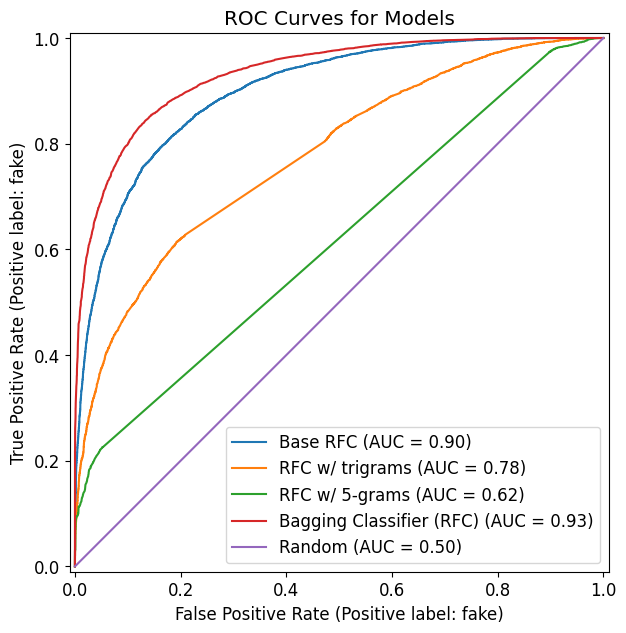

In [20]:
plt.figure(figsize=(7,7))
matplotlib.rcParams.update({'font.size': 12})
RocCurveDisplay.from_estimator(rfc, tfidf_test_arts_vector, testing_labels, ax=plt.gca(),pos_label="fake", name='Base RFC')
RocCurveDisplay.from_estimator(rfc_trigram, count_tri_test_arts_vector, testing_labels, ax=plt.gca(), pos_label="fake", name='RFC w/ trigrams')
RocCurveDisplay.from_estimator(rfc_fivegram, count_five_test_arts_vector, testing_labels, ax=plt.gca(), pos_label="fake", name='RFC w/ 5-grams')
RocCurveDisplay.from_estimator(bgc, tfidf_test_arts_vector, testing_labels, ax=plt.gca(), pos_label="fake", name='Bagging Classifier (RFC)')
RocCurveDisplay.from_estimator(dclf, tfidf_test_arts_vector, testing_labels, ax=plt.gca(), pos_label="fake", name='Random')
plt.title("ROC Curves for Models")

Text(0.5, 1.0, 'PRC Curves for Models')

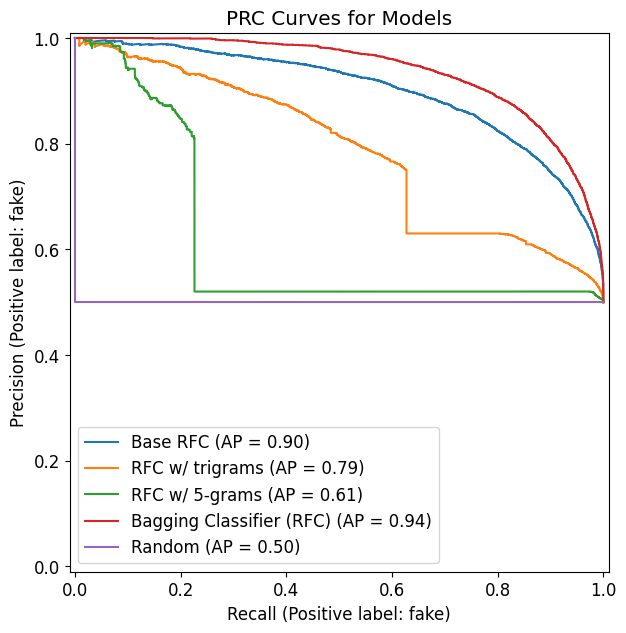

In [21]:
plt.figure(figsize=(7,7))

PrecisionRecallDisplay.from_estimator(rfc, tfidf_test_arts_vector, testing_labels, ax=plt.gca(),pos_label="fake", name='Base RFC')
PrecisionRecallDisplay.from_estimator(rfc_trigram, count_tri_test_arts_vector, testing_labels, ax=plt.gca(), pos_label="fake", name='RFC w/ trigrams')
PrecisionRecallDisplay.from_estimator(rfc_fivegram, count_five_test_arts_vector, testing_labels, ax=plt.gca(), pos_label="fake", name='RFC w/ 5-grams')
PrecisionRecallDisplay.from_estimator(bgc, tfidf_test_arts_vector, testing_labels, ax=plt.gca(), pos_label="fake", name='Bagging Classifier (RFC)')
PrecisionRecallDisplay.from_estimator(dclf, tfidf_test_arts_vector, testing_labels, ax=plt.gca(), pos_label="fake", name='Random')
plt.title("PRC Curves for Models")

In [22]:
models = ["rfc", "rfc_trigram", "rfc_fivegram", "bgc"]
predictions = [rfc.predict(tfidf_test_arts_vector), 
               rfc_trigram.predict(count_tri_test_arts_vector),
               rfc_fivegram.predict(count_five_test_arts_vector),
               bgc.predict(tfidf_test_arts_vector)
            ]

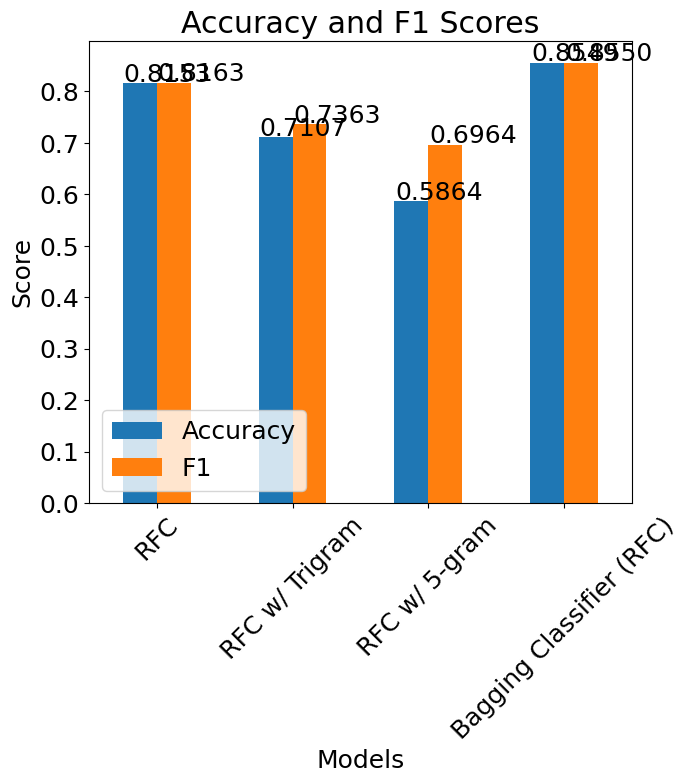

In [ ]:
accuracy_scores = [accuracy_score(testing_labels, prediction) for prediction in predictions]
f1_scores = [f1_score(testing_labels, prediction, pos_label="real") for prediction in predictions]

df = pd.DataFrame({"Accuracy" : accuracy_scores, "F1" : f1_scores},index=["RFC", "RFC w/ Trigram", "RFC w/ 5-gram", "Bagging Classifier (RFC)"])
ax = df.plot(kind='barh', rot=45, figsize=(7, 6))
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() * 1.005, p.get_height() * 1.005))
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Accuracy and F1 Scores")
plt.show()


C:\Users\Shizuwu\AppData\Local\Temp\ipykernel_195316\3594889275.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Shizuwu\AppData\Local\Temp\ipykernel_195316\3594889275.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Shizuwu\AppData\Local\Temp\ipykernel_195316\3594889275.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Shizuwu\AppData\Local\Temp\ipykernel_195316\3594889275.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


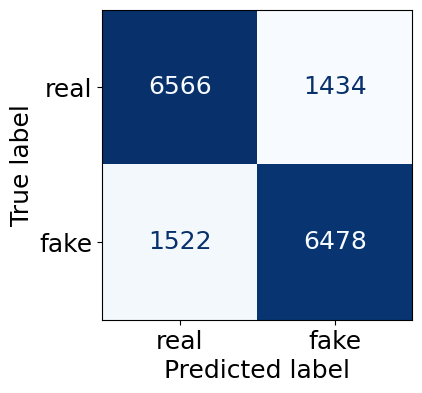

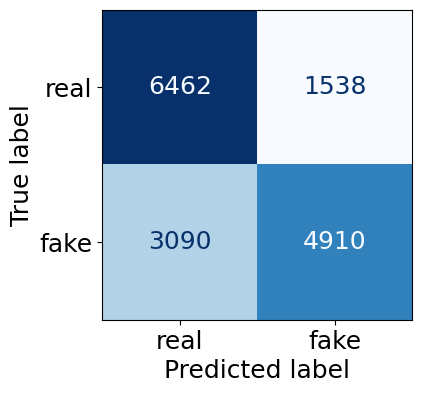

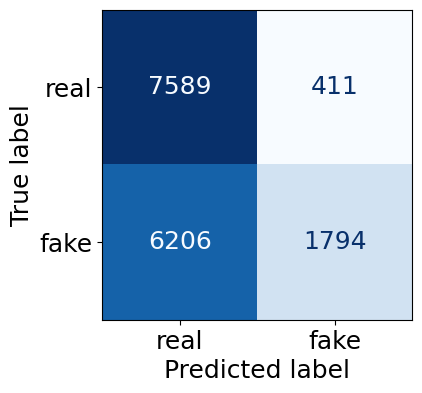

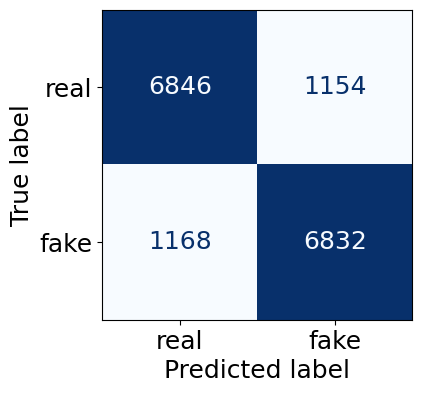

In [24]:
labels = ['real','fake']
matplotlib.rcParams.update({'font.size': 18})
for prediction in predictions:
    fig, axes = plt.subplots(figsize=(5,5))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(testing_labels, prediction, labels=labels)).plot(ax=axes, cmap=plt.cm.Blues)
    axes.set_xticklabels(labels)
    axes.set_yticklabels(labels)
    fig.delaxes(fig.axes[1])
    fig.show()